In [ ]:
#Some of the code and comments based on the MAB posts by Steve Roberts:
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

In [1]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
import random
%matplotlib inline
from scipy.stats import binom

In [39]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)

df = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_AL-GA_actions_taken_1-3.csv")
print(len(df))
extra1 = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_AR-MS_actions_taken_1-3.csv")
print(len(extra1))
extra2 = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_TN-LA_actions_taken_1-3.csv")
print(len(extra2))

subsample = pd.concat([df,extra1,extra2])

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==3]))
subsample = subsample.loc[subsample["action_taken"].isin([1,3])]
subsample["action_taken"] = subsample["action_taken"].replace([3],[0])    
print("action:",subsample["action_taken"].unique())
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print("race pre:",subsample["derived_race"].unique())
subsample = subsample.loc[subsample["derived_race"].isin(["White","Black or African American"])]
subsample["derived_race"] = subsample["derived_race"].replace(["White","Black or African American"],[0,1])
print("race:",subsample["derived_race"].unique())

print("ethnicity pre:",subsample["derived_ethnicity"].unique())
subsample = subsample.loc[subsample["derived_ethnicity"].isin(['Not Hispanic or Latino','Hispanic or Latino'])]
subsample["derived_ethnicity"] = subsample["derived_ethnicity"].replace(['Not Hispanic or Latino','Hispanic or Latino'],[0,1])
print("ethnicity:",subsample["derived_ethnicity"].unique())

print("sex pre",subsample["derived_sex"].unique())
subsample = subsample.loc[subsample["derived_sex"].isin(['Male','Female'])]
subsample["derived_sex"] = subsample["derived_sex"].replace(['Male','Female'],[0,1])
print("sex:",subsample["derived_sex"].unique())

subsample = subsample.loc[subsample["interest_rate"]!='Exempt']
subsample = subsample.loc[subsample["loan_to_value_ratio"]!='Exempt']
subsample = subsample.loc[subsample["property_value"]!='Exempt']

print(len(subsample))

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


788548
226310
542847
1259305 298400
action: [1 0]
1259305 298400
race pre: ['Asian' 'White' 'Black or African American' 'Race Not Available'
 '2 or more minority races' 'Joint' 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Free Form Text Only']
race: [0 1]
ethnicity pre: ['Not Hispanic or Latino' 'Hispanic or Latino' 'Joint'
 'Ethnicity Not Available' 'Free Form Text Only']
ethnicity: [0 1]
sex pre ['Female' 'Joint' 'Male' 'Sex Not Available']
sex: [1 0]
717997


In [40]:
from matplotlib import pyplot as plt
#sensitive = ["applicant_race-1","applicant_ethnicity-1","applicant_sex"]
sensitive = ["derived_race","derived_ethnicity","derived_sex"]
def show_subgroups(df,bool_app_dec,bool_percent):
  subgroups = []
  subgroups_names = []
  R = ["W","B"]
  E = ["NH","H"]
  S = ["M","F"]
  for option in [0,1]:
    for option2 in [0,1]:
      for option3 in [0,1]:
          subgroups.append(df.loc[((df[sensitive[0]]==option) & (df[sensitive[1]]==option2) & (df[sensitive[2]]==option3))])
          subgroups_names.append(R[option]+"_"+E[option2]+"_"+S[option3])
  subgroups_app = []
  subgroups_dec = []
  percent = []
  for s in subgroups:
    #print(s["action_taken"])
    subgroups_app.append(len(s[s["action_taken"]==1]))
    subgroups_dec.append(len(s[s["action_taken"]==0]))
    if(len(s)!=0):
      percent.append(round(100*len(s[s["action_taken"]==1])/len(s),2))
    else:
      percent.append(0)
    #print(percent[-1],"%")

  fig = plt.figure()
  if(bool_app_dec):
    ax = fig.add_axes([0,0,1,1])
    ax.bar(subgroups_names,subgroups_app, color='r')
    ax.bar(subgroups_names,subgroups_dec, bottom=subgroups_app, color='b')
    ax.legend(labels=['Accepted', 'Denied'],fontsize="x-large")
  if(bool_percent):
    ax2 = fig.add_axes([0,0,1,1])
    ax2.bar(subgroups_names,percent)
    ax2.legend(labels=['Approval rate'],fontsize="x-large")
    plt.plot(subgroups_names, [50]*8, color = "red", linestyle="--")
  if(bool_app_dec or bool_percent):
    plt.show()
  return (subgroups,subgroups_names,subgroups_app,subgroups_dec,percent)

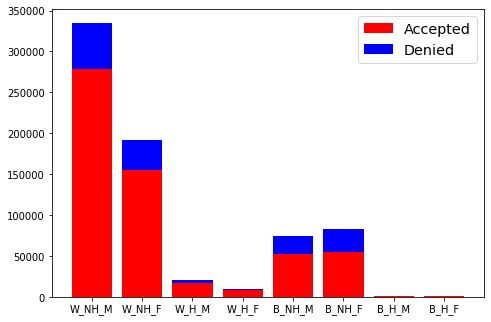

In [45]:
subgroups = show_subgroups(subsample,True,False)

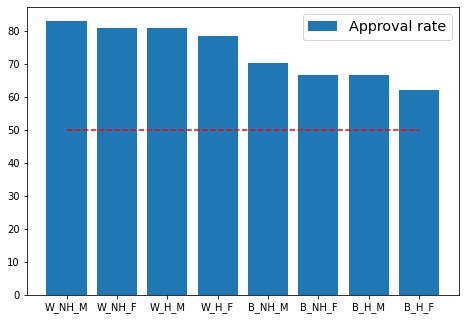

[83.0, 80.77, 80.88, 78.26, 70.15, 66.39, 66.58, 61.92]

In [46]:
subgroups = show_subgroups(subsample,False,True)
subgroups[4]

contribution to total approvals: [0.491, 0.273, 0.029, 0.014, 0.092, 0.098, 0.002, 0.002]
contribution to total amount   : [0.467, 0.267, 0.028, 0.014, 0.103, 0.116, 0.002, 0.002]


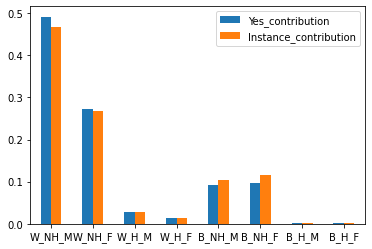

In [47]:
yes_contribution = [round(s / sum(subgroups[2]),3) for s in subgroups[2]]
instance_contribution = [round(len(s) / len(subsample),3) for s in subgroups[0]]
print("contribution to total approvals:",yes_contribution)
print("contribution to total amount   :",instance_contribution)
plot_contribution = pd.DataFrame({'Yes_contribution': yes_contribution,
                   'Instance_contribution': instance_contribution}, index=subgroups[1])
ax = plot_contribution.plot.bar(rot=0, figsize=(6,4))

In [3]:
class ArmProb:
    """ the base power arm class """
    
    def __init__(self, q, cl):                
        self.q = q        # the true reward value 
        self.confidence_level = cl  
        self.initialize() # reset the arm
        
    def initialize(self):
        self.Q = 0   # the estimate of this arm's reward value                
        self.n = 0   # the number of times this arm has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        ##value = self.q + np.random.randn() * self.var
        value = 100 * np.random.binomial(1,self.q)     
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this arm after it has returned reward value 'R' """     
    
        # increment the number of times this arm has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this arm's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [2]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

# return the index of the smallest value in the supplied list
# - arbitrarily select between the smallest values in the case of a tie
# (the standard np.argmin just chooses the first value in the case of a tie)
def random_argmin(value_list):
  """ a random tie-breaking argmin"""
  values = np.asarray(value_list)
  return np.argmin(np.random.random(values.shape) * (values==values.min()))


In [89]:
class solutionBatchProb():
    """ create and test a set of arms over a single test run """

    def __init__(self, arm, arm_order, confidence_level, sub_opt, const_name="bias_presence_hipo"):  
        
        self.subopt_coef = sub_opt
        self.const_name = const_name
        self.const_names = {"bias_presence_hipo":self.bias_presence_hipo, 
                            "bias_rate_hipo":self.bias_rate_hipo,
                            "bias_rate2_hipo":self.bias_rate2_hipo,
                            "bias_posteriors_hipo":self.bias_posteriors_hipo,
                            "bias_rewards_hipo":self.bias_rewards_hipo}

        # create supplied arm type with a mean value defined by arm order 
        self.arms = [arm(arm_order[s], confidence_level) for s in range(len(arm_order))]
        
        # set the number of arms equal to the number created
        self.number_of_arms = len(self.arms)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.arm_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_arms, 
                                            self.number_of_stats))
        
        # ensure that all arms are re-initialized
        for arm in self.arms: arm.initialize()
            
                                
    def charge_and_update(self,arm_index):
        """ charge from & update the specified arm and associated parameters """
        
        # charge from the chosen arm and update its mean reward value
        reward = self.arms[arm_index].charge()
        self.arms[arm_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_arm_stats( self, t ):
        """ get the current information from each arm """        
        arm_stats = [[arm.Q, arm.n] for arm in self.arms]
        return arm_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each arm's reward at each timestep of the run """
        return self.arm_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each arm at each timestep of the run """
        return self.arm_stats[:,:,1]          
                
    def get_arm_percentages( self ):
        """ get the percentage of times each arm was tried over the run """
        return (self.arm_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def bias_presence_hipo(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        bias_list = []
        for c in range(len(self.arms)):
          pulled = self.get_number_of_trials()[t].copy()
          pulled[c]+=1
          selected_presence = np.array(pulled/(t+1))
          diff = np.subtract(selected_presence, presence)
          #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list
    
    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.arms)):
          pulled = self.arm_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
          overall_percentages = np.mean(curr_percentages)
          diff = np.subtract(np.mean(curr_percentages),curr_percentages)
          #diff = np.subtract(self.capping,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list
    
    def bias_rate2_hipo(self, t):
        bias_list = []
        for c in range(len(self.arms)):
          pulled = self.arm_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
          overall_percentages = np.mean(curr_percentages)
          diff = np.subtract(max(curr_percentages),curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_posteriors_hipo(self, t):
        #P(c in C_i | c is approved ) = P( c is approved | c in C_i ) * P( c in C_i ) / P( c is approved )
        A = np.array([i/sum(self.possibles) for i in self.possibles])
        B = self.capping
        bias_list = []
        for c in range(len(self.arms)):
          pulled = self.get_number_of_trials()[t].copy()
          pulled[c]+=1
          B_A = np.array([pulled[i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
          A_B = np.divide(np.multiply(B_A,A),B, out=np.zeros_like(np.multiply(B_A,A)), where=B!=0)
          #print(A_B)
          diff = np.subtract(np.mean(A_B),A_B)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list
    
    def bias_rewards_hipo(self, t):
        rewards_distributions = self.get_estimates()[t]
        mean_d = np.mean(rewards_distributions)
        bias_list = np.subtract(rewards_distributions,mean_d)
        return bias_list

    def bias_presence_step(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_number_of_trials()[t]/t)
        diff = np.subtract(selected_presence, presence)
        #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        abs = np.abs(diff)
        return np.sum(abs) 

    def bias_rate_step(self, t):
        percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
        overall_percentages = np.mean(percentages)
        #print(overall_percentages)
        diff = np.subtract(overall_percentages,percentages)
        abs = np.abs(diff)
        return np.sum(abs)

    def final_bias_presence(self):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_arm_percentages())
        diff = np.subtract(selected_presence, presence)
        abs = np.abs(diff)
        return np.sum(abs) 
    
    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
        overall_percentages = np.mean(final_percentages)
        #print(overall_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs)

    def final_bias_posteriors(self):
        #P(c in C_i | c is approved ) = P( c is approved | c in C_i ) * P( c in C_i ) / P( c is approved )
        B_A = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] if self.possibles[i]>0.0 else 0.0 for i in range(len(self.arms))])
        A = np.array([i/sum(self.possibles) for i in self.possibles])
        B = self.total_steps/sum(self.possibles)
        A_B = np.divide(np.multiply(B_A,A),B, out=np.zeros_like(np.multiply(B_A,A)), where=B!=0)
        #print(A_B)
        diff = np.subtract(np.mean(A_B),A_B)
        abs = np.abs(diff)
        return np.sum(abs)

    def final_bias_rewards(self):
        rewards_distributions = np.divide(self.get_estimates()[self.total_steps],100)
        mean_d = np.mean(rewards_distributions)
        diff = np.subtract(max(rewards_distributions),rewards_distributions)
        abs = np.abs(diff)
        return np.sum(abs)

    def punishing_term(self,bias_func,t):
        b_list = bias_func(t)
        norm_num = np.subtract(b_list,min(b_list))
        norm_denom = np.subtract(max(b_list),min(b_list))
        aux_b_list = np.divide(norm_num,norm_denom, out=np.zeros_like(norm_num), where=norm_denom!=0)
        #print(aux_b_list)
        return np.multiply(aux_b_list,100)

    """
    def select_arm_prob( self, t ):
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.arms))]
        available_arms = [self.arms[s] for s in range(len(self.arms)) if (mask[s])]
        available = [i for i in range(len(self.arms)) if (mask[i])]

        bias_term = self.punishing_term(self.bias_presence_hipo,t)

        arm_max = random_argmax([self.arms[arm].sample(t+1) for arm in available]) 
        arm_max_index = self.arms.index(available_arms[arm_max])
        
        arm_min = random_argmin([bias_term[arm] for arm in available]) 
        arm_min_index = self.arms.index(available_arms[arm_min])

        return_index = random.choices([arm_min_index,arm_max_index],cum_weights=[self.subopt_coef,1])

        return return_index[0]   
    """

    def select_arm( self, t ):
              
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.arms))]
        available_arms = [self.arms[s] for s in range(len(self.arms)) if (mask[s])]
        available = [i for i in range(len(self.arms)) if (mask[i])]

        bias_term = self.punishing_term(self.const_names[self.const_name],t)

        #to avoid error with 0.0*float('inf')
        if self.subopt_coef!=1.0:
          arm_max = random_argmax([(1.0-self.subopt_coef)*self.arms[arm].sample(t+1)-self.subopt_coef*bias_term[arm] for arm in available]) 
        else:
          arm_max = random_argmax([-bias_term[arm] for arm in available])

        arm_index = self.arms.index(available_arms[arm_max])
        return arm_index
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_arm_percentages())
        diff = np.subtract(selected_presence, presence)
        diff1 = np.add(1,diff)
        diff2 = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        diff2 = np.add(1,diff2)
        #print(diff1,diff2)
        #print(diff.sum())
        return diff2
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of arms, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        self.capping = max_percent_decisions
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)
        self.presence_step = []
        self.rate_step = []
        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):
            self.arm_stats[t] = self.get_arm_stats(t)     
            arm_index = self.select_arm(t)
            if(self.get_number_of_trials()[t][arm_index]<self.possibles[arm_index]):
              # charge from the chosen arm and update its mean reward value
              self.charge_and_update(arm_index)
              usos+=1
              if usos > usos_maxims:
                  break
            
            if t%10==0:
              self.presence_step.append(self.bias_presence_step(t))
              self.rate_step.append(self.bias_rate_step(t))


        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each arm at the end of the run        
        self.arm_stats[t+1] = self.get_arm_stats(t+1)           
        
        self.approval_rates = [round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))]
        self.regret = 100*max([s.q for s in self.arms])-self.get_mean_reward()
        self.regret2 = usos_maxims*100*max([s.q for s in self.arms])-self.total_reward
        #print(self.regret)
        if(prints_bool):
          #print("possibles",self.possibles)
          print("Reward distribution:",[round(s.q,4) for s in self.arms])
          print("Final estimates:",[round(e/100,4) for e in self.get_estimates()[self.total_steps]])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",self.approval_rates)
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_arm_percentages()])
          print("Total reward:",self.total_reward,"|| and presence bias:",self.final_bias_presence())
          print("Rate bias:",self.final_bias_rate())
          print("Posteriors bias:",self.final_bias_posteriors())
          print("Rewards bias:",self.final_bias_rewards())
          print("Final regret:",self.regret)
          #print(self.return_increments(decisions_to_consider))
        return_dic = {
            "total_steps":self.total_steps,
            "total_reward":self.total_reward,
            "increments":self.return_increments(decisions_to_consider),
            "estimates":[e/100 for e in self.get_estimates()[self.total_steps]],
            "bias_presence":self.final_bias_presence(),
            "bias_rate":self.final_bias_rate(),
            "bias_posteriors":self.final_bias_posteriors(),
            "bias_rewards":self.final_bias_rewards(),
            "app_rate":self.approval_rates,
            "percentages":self.get_arm_percentages(),
            "presence_step":self.presence_step,
            "rate_step":self.rate_step,
            "regret":self.regret,
            "regret2":self.regret2,
            "n_trial_tstep":self.get_number_of_trials()
        }
        return return_dic

In [30]:
rewards_bias = np.array([.830, .8077, .8088, .7826, .7015, .6639, .6658, .6192])
rewards_nonbias = [0.8]*8

instances_bias = np.array([0.467, 0.267, 0.028, 0.014, 0.103, 0.116, 0.002, 0.002])
instances_nonbias = [1/8]*8

In [12]:
rate_results = []
contribution_results = []

i_values = instances_bias #instances_nonbias
r_values = rewards_bias #rewards_nonbias

decisions = random.choices(range(8),weights=list(i_values),k=2500)
sol_test = solutionBatchProb(ArmProb, r_values, 25, 0)

for sopt in range(100):
  rd = sol_test.run(decisions, 0.8, False)
  rate_results.append(rd["app_rate"])
  contribution_results.append(rd["percentages"])

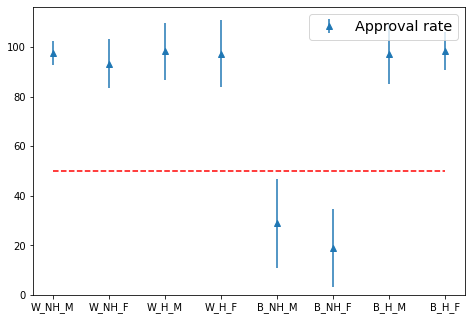

In [13]:
xar = ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"] #np.arange(8)
yar = [np.mean(np.transpose(rate_results)[i]) for i in range(8)]
ear = [np.std(np.transpose(rate_results)[i]) for i in range(8)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.errorbar(xar, yar, ear, linestyle='None', marker='^', label="Approval rate")
plt.plot(xar, [50]*8, color = "red", linestyle="--")
ax.set_ylim(0,)
ax.legend(fontsize="x-large")
plt.show()

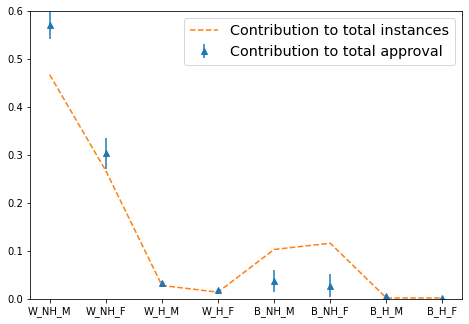

In [14]:
xac = ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"]
yac = [np.mean(np.transpose(contribution_results)[i]) for i in range(8)]
eac = [np.std(np.transpose(contribution_results)[i]) for i in range(8)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.errorbar(xac, yac, eac, linestyle='None', marker='^', label="Contribution to total approval")
ax.plot(xac, list(i_values), linestyle='--', label = "Contribution to total instances")
ax.set_ylim(0,0.6)
ax.legend(fontsize="x-large")
plt.show()

In [17]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [16]:
def plot_values(m, trend, labels, lim=False):
  x = range(len(m))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  if(lim!=False):
    ax.set_ylim(lim)
  for i in range(len(m[0])):
    y = [m[j][i] for j in range(len(m))]
    ax.plot(x, y)
    if(trend):
      z = np.polyfit(x, y, 1)
      p = np.poly1d(z)
      ax.plot(x, p(x), color = colors[i], linestyle="--", label='_nolegend_')
  ax.legend(labels)
  plt.show()

In [19]:
def plot_percen(m):
  x = range(len(m))
  y = np.array([m[j][0] for j in range(len(m))])
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x,y,align='edge',width=1.0)
  Y = [y]
  for i in range(1,len(m[0])):
    ax.bar(x, [m[j][i] for j in range(len(m))], bottom=y, align='edge',width=1.0)
    y = np.add(y,np.array([m[j][i] for j in range(len(m))]))
  ax.legend(labels=["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"])
  ax.grid(False)
  plt.show()

In [50]:
def nonstatic_sol(iter, rewards_d_o_mu, r_coef, instances_d_o, i_coef, sub_opt):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  rewards_his = []
  instances_hist = [] 
  percentages_hist = []
  bias_hist = []
  rew_hist = []

  for i in range(iter):
    pbool=False
    #if(i%math.ceil(iter/4)==0 or i==iter-1):
    if(i==0 or i==iter-1):
        print(i)
        pbool=True

    if(i%math.ceil(iter/20)==0 or i==iter-1):
      rewards_his.append(rewards_d)
      instances_hist.append(instances_d)

    updated_test = solutionBatchProb(ArmProb, list(rewards_d), 25, sub_opt)
    decisions = random.choices(range(8),weights=list(instances_d),k=2500)
    rd = updated_test.run(decisions, 0.8, pbool)

    #if(i%math.ceil(iter/25)==0 or i==iter-1):
    percentages_hist.append(rd["percentages"])

    bias_hist.append([rd["bias_rate"],rd["bias_posteriors"],rd["bias_rewards"],rd["bias_presence"]])
    rew_hist.append(rd["total_reward"])
    #print(rew_hist)

    r_update = rd["estimates"]
    i_update = rd["increments"]

    old_r_term = np.multiply(rewards_d,1-r_coef)
    new_r_term = np.multiply(np.multiply(r_update,i_update),r_coef)
    rewards_d = np.add(old_r_term,new_r_term)
    rewards_d = np.clip(rewards_d,0.001,0.999)

    old_i_term = np.multiply(instances_d,1-i_coef)
    new_i_term = np.multiply(np.multiply(instances_d,i_update),i_coef)
    instances_d = np.add(old_i_term,new_i_term)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()
  
  plot_values(instances_hist, False, ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"], (0,1))
  plot_values(rewards_his, False, ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"], (0.5,1))
  plot_percen(percentages_hist)
  plot_values([[bias_hist[i][3]] for i in range(len(bias_hist))],  True, ["bias_presence"], (0,0.4))
  plot_values([bias_hist[i][:3] for i in range(len(bias_hist))], True, ["bias_rate","bias_posteriors","bias_rewards"], (0,3.3))
  plot_values(np.transpose([rew_hist]), True, ["total_reward"], (140000, 184000))
  #plt.show()
  
  return [instances_hist, rewards_his, percentages_hist, bias_hist, rew_hist]

0
Reward distribution: [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
Final estimates: [0.0, 0.7912, 0.7956, 0.798, 0.7877, 0.8226, 0.7869, 0.81]
Presence of each in batch (%): [12.68, 11.88, 12.72, 12.08, 13.2, 12.4, 12.2, 12.84]
Relative approval rate (%): [0.32, 100.0, 100.0, 100.0, 44.24, 100.0, 100.0, 100.0]
Percentage over total selected (%): [0.05, 14.84, 15.89, 15.09, 7.3, 15.49, 15.24, 16.04]
Total reward: 159900 || and presence bias: 0.3701737131434283
Rate bias: 2.3316317751648983
Posteriors bias: 0.35282358820589704
Rewards bias: 0.9886826694430141
Final regret: 0.08995502248875198
99
Reward distribution: [0.7005, 0.6989, 0.7078, 0.7321, 0.7919, 0.7734, 0.759, 0.6969]
Final estimates: [0.6915, 0.7229, 0.7357, 0.7548, 0.7604, 0.8156, 0.7723, 0.0]
Presence of each in batch (%): [11.28, 11.44, 11.2, 12.4, 13.52, 14.32, 13.88, 11.96]
Relative approval rate (%): [100.0, 29.02, 100.0, 100.0, 100.0, 100.0, 100.0, 0.67]
Percentage over total selected (%): [14.09, 4.15, 13.99, 15.49, 16.8

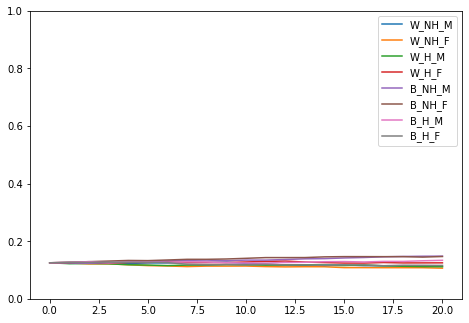

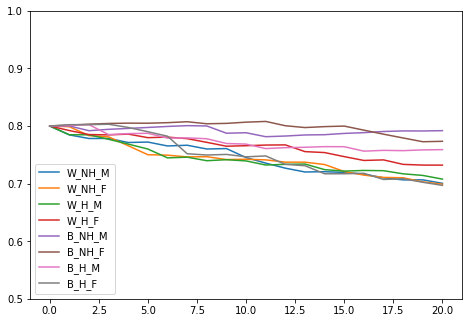

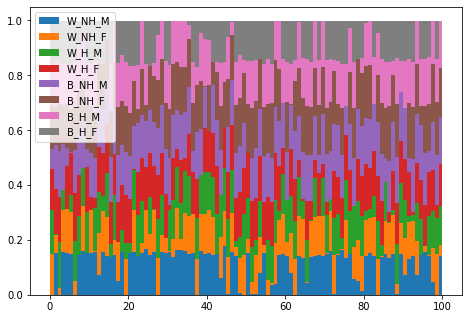

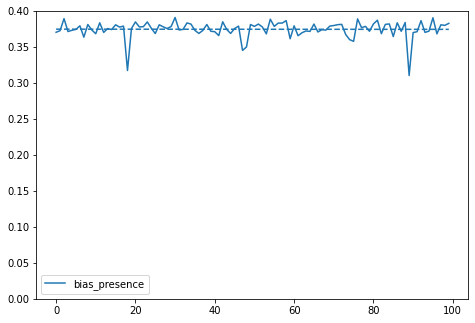

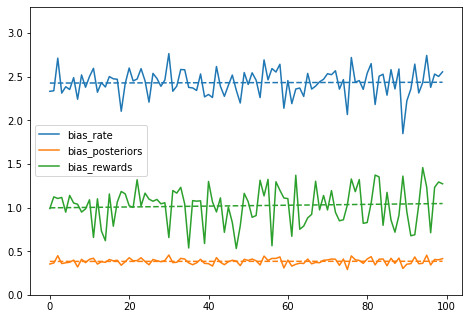

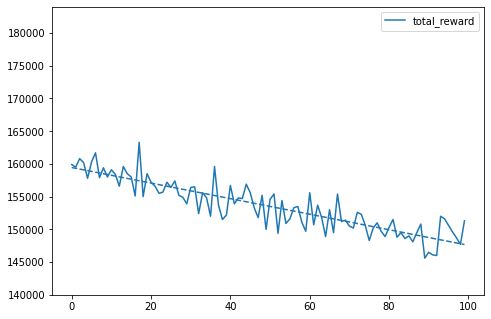

In [52]:
r = nonstatic_sol(100, rewards_nonbias, 0.01, instances_nonbias, 0.1, 0)

0
Reward distribution: [0.83, 0.8077, 0.8088, 0.7826, 0.7015, 0.6639, 0.6658, 0.6192]
Final estimates: [0.8173, 0.8238, 0.4, 0.8, 0.7143, 0.6429, 0.0, 0.3333]
Presence of each in batch (%): [47.72, 25.44, 2.88, 1.2, 10.44, 11.88, 0.2, 0.24]
Relative approval rate (%): [100.0, 91.04, 6.94, 100.0, 61.69, 9.43, 20.0, 50.0]
Percentage over total selected (%): [59.62, 28.94, 0.25, 1.5, 8.05, 1.4, 0.05, 0.15]
Total reward: 161300 || and presence bias: 0.31439920039980007
Rate bias: 2.6635150573179196
Posteriors bias: 1.2713643178410796
Rewards bias: 2.0590957946355877
Final regret: 2.3903048475762176
99
Reward distribution: [0.9388, 0.7786, 0.8076, 0.7819, 0.6762, 0.6328, 0.6658, 0.6191]
Final estimates: [0.936, 0.7, 0.625, 0.0, 0.0, 0.6, 1.0, 0.0]
Presence of each in batch (%): [80.4, 9.48, 1.32, 0.6, 4.0, 3.92, 0.16, 0.12]
Relative approval rate (%): [98.01, 4.22, 24.24, 6.67, 1.0, 5.1, 100.0, 33.33]
Percentage over total selected (%): [98.45, 0.5, 0.4, 0.05, 0.05, 0.25, 0.2, 0.05]
Total r

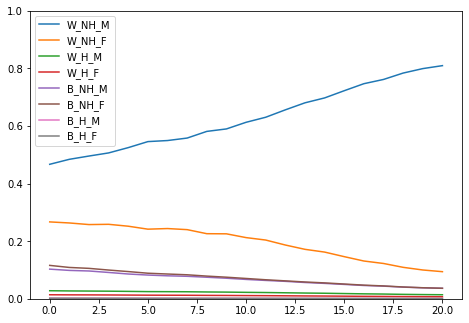

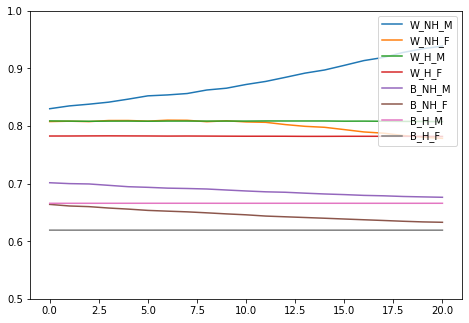

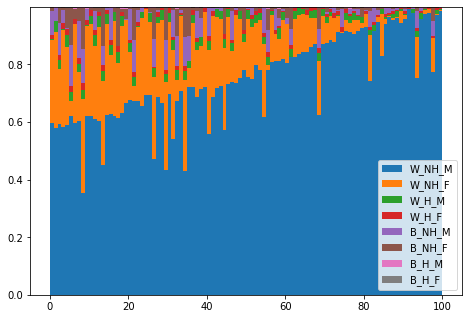

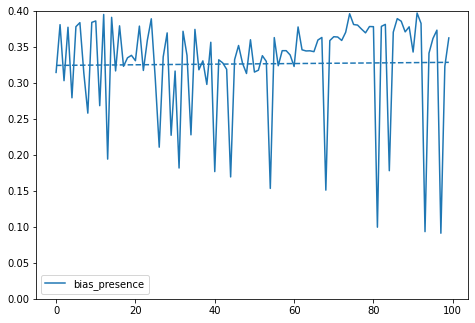

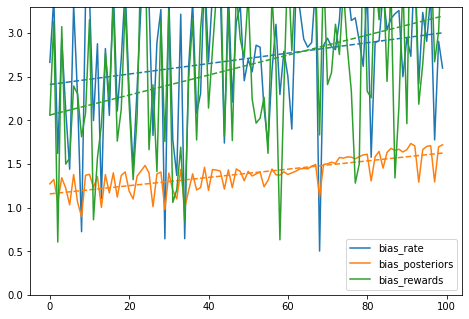

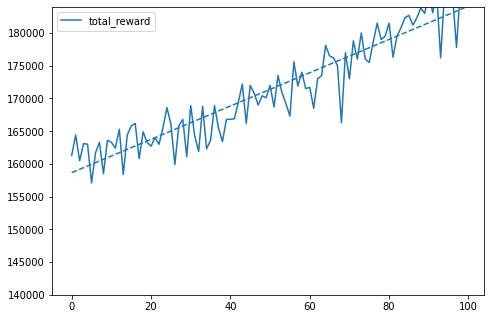

In [32]:
r = nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0)

In [55]:
np.seterr(all="raise")
rwd_results = []
presence_results = []
rate_results = []
posteriors_results = []
rewards_results = []
regret_results = []
regret2_results = []
decisions = random.choices(range(8),weights=list(instances_bias),k=2500)
for sopt in np.arange(0,1.05,0.05):
  sopt_i_rwd_results = []
  sopt_i_presence_results = []
  sopt_i_rate_results = []
  sopt_i_posteriors_results = []
  sopt_i_rewards_results = []
  sopt_i_regret_results = []
  sopt_i_regret2_results = []

  sol_test = solutionBatchProb(ArmProb, rewards_bias, 25, sopt) #default: bias_presence_hipo // bias_rate_hipo, bias_posteriors_hipo, bias_rewards_hipo

  for iter in range(50):
    rd = sol_test.run(decisions, 0.8, False)
    sopt_i_rwd_results.append(rd["total_reward"])
    sopt_i_presence_results.append(rd["bias_presence"])
    sopt_i_rate_results.append(rd["bias_rate"])
    sopt_i_posteriors_results.append(rd["bias_posteriors"])
    sopt_i_rewards_results.append(rd["bias_rewards"])
    sopt_i_regret_results.append(rd["regret"])
    sopt_i_regret2_results.append(rd["regret2"])
  rwd_results.append([np.mean(sopt_i_rwd_results),np.std(sopt_i_rwd_results)])
  presence_results.append([np.mean(sopt_i_presence_results),np.std(sopt_i_presence_results)])
  rate_results.append([np.mean(sopt_i_rate_results),np.std(sopt_i_rate_results)])
  posteriors_results.append([np.mean(sopt_i_posteriors_results),np.std(sopt_i_posteriors_results)])
  rewards_results.append([np.mean(sopt_i_rewards_results),np.std(sopt_i_rewards_results)])
  regret_results.append([np.mean(sopt_i_regret_results),np.std(sopt_i_regret_results)])
  regret2_results.append([np.mean(sopt_i_regret2_results),np.std(sopt_i_regret2_results)])
print([rwd_results[i][0] for i in range(len(rwd_results))])
print([presence_results[i][0] for i in range(len(presence_results))])

[160800.0, 161686.0, 161546.0, 159890.0, 159134.0, 158702.0, 158326.0, 158554.0, 157692.0, 158418.0, 157990.0, 157722.0, 157850.0, 158240.0, 158096.0, 158008.0, 158030.0, 158106.0, 157828.0, 158088.0, 158644.0]
[0.3374228165917041, 0.32899254372813586, 0.28495516241879054, 0.18995614192903554, 0.10274263668165919, 0.037001899050474775, 0.015113187406296857, 0.002082438780609695, 0.0015891814092953514, 0.0013956061969015473, 0.0013777591204397767, 0.0013765917041479233, 0.0013728495752123922, 0.0013815812093952978, 0.0013840759620189851, 0.00138906546726636, 0.001392807596201891, 0.0013903128435782037, 0.0013940549725137347, 0.001395302348825578, 0.001395302348825578]


In [56]:
import matplotlib.pyplot as plt
import numpy as np

xr = np.arange(0,1.05,0.05)
yr = [rwd_results[i][0] for i in range(len(rwd_results))]
er = [rwd_results[i][1] for i in range(len(rwd_results))]

xpres = np.arange(0,1.05,0.05)
ypres = [presence_results[i][0] for i in range(len(presence_results))]
epres = [presence_results[i][1] for i in range(len(presence_results))]

xrate = np.arange(0,1.05,0.05)
yrate = [rate_results[i][0] for i in range(len(rate_results))]
erate = [rate_results[i][1] for i in range(len(rate_results))]

xpost = np.arange(0,1.05,0.05)
ypost = [posteriors_results[i][0] for i in range(len(posteriors_results))]
epost = [posteriors_results[i][1] for i in range(len(posteriors_results))]

xrb = np.arange(0,1.05,0.05)
yrb = [rewards_results[i][0] for i in range(len(rewards_results))]
erb = [rewards_results[i][1] for i in range(len(rewards_results))]

xregr = np.arange(0,1.05,0.05)
yregr = [regret_results[i][0] for i in range(len(regret_results))]
eregr = [regret_results[i][1] for i in range(len(regret_results))]

xregr2 = np.arange(0,1.05,0.05)
yregr2 = [regret2_results[i][0] for i in range(len(regret2_results))]
eregr2 = [regret2_results[i][1] for i in range(len(regret2_results))]

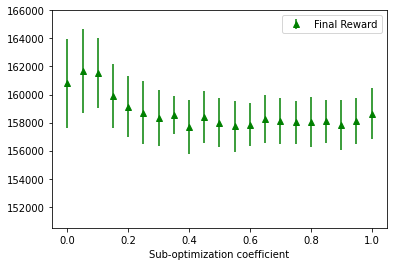

In [57]:
plt.errorbar(xr, yr, er, linestyle='None', marker='^',color="green", label="Final Reward")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(150500,166000)
plt.legend()
plt.show() #total rewards (y) vs subopt value (x)

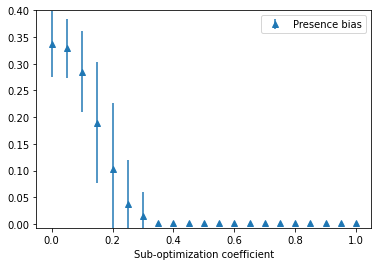

In [58]:
plt.errorbar(xpres, ypres, epres, linestyle='None', marker='^', label="Presence bias")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(-0.007,0.4)
plt.legend()
plt.show()  #final presence bias (y) vs subopt value (x)

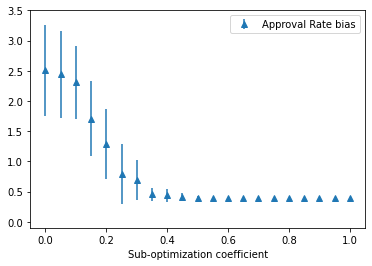

In [59]:
plt.errorbar(xrate, yrate, erate, linestyle='None', marker='^', label="Approval Rate bias")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(-0.1,3.5)
plt.legend()
plt.show()  #final approval rate bias (y) vs subopt value (x)

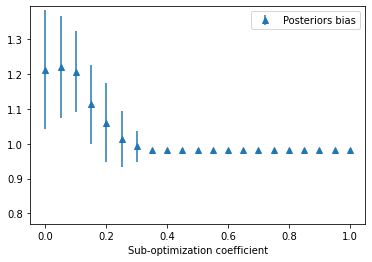

In [60]:
plt.errorbar(xpost, ypost, epost, linestyle='None', marker='^', label="Posteriors bias")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(0.77,1.395)
plt.legend()
plt.show()  #final posteriors bias (y) vs subopt value (x)


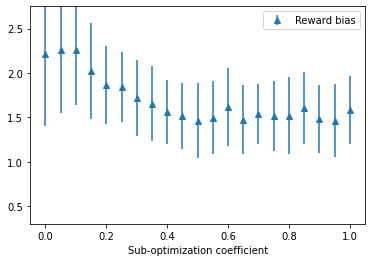

In [61]:
plt.errorbar(xrb, yrb, erb, linestyle='None', marker='^', label="Reward bias")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(0.3,2.75)
plt.legend()
plt.show()  #final rewards bias (y) vs subopt value (x)

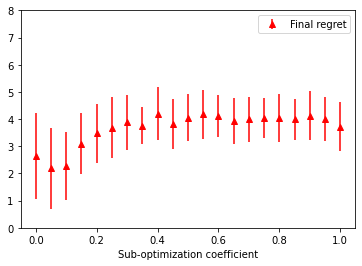

In [62]:
plt.errorbar(xregr, yregr, eregr, linestyle='None', marker='^', color="red", label="Final regret")
plt.xlabel("Sub-optimization coefficient")
plt.ylim(0,8)
plt.legend()
plt.show()  #final regret (y) vs subopt value (x)

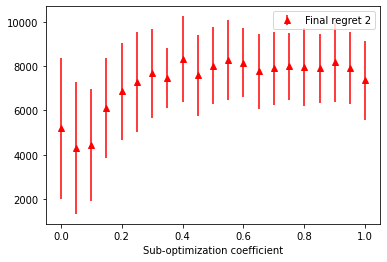

In [63]:
plt.errorbar(xregr2, yregr2, eregr2, linestyle='None', marker='^', color="red", label="Final regret 2")
plt.xlabel("Sub-optimization coefficient")
plt.legend()
plt.show()  #final regret 2 (y) vs subopt value (x)

In [64]:
def minmax(l):
  norm_num = np.subtract(l,min(l))
  norm_denom = np.subtract(max(l),min(l))
  aux_list = np.divide(norm_num,norm_denom, out=np.zeros_like(norm_num), where=norm_denom!=0)
  #print(aux_list)
  return aux_list

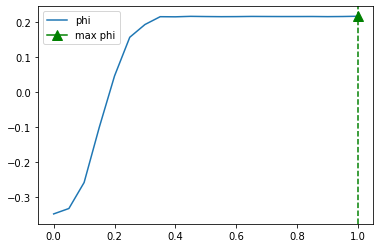

In [69]:
#norm_r = minmax(yr)
norm_r = yr/np.linalg.norm(yr) 

#norm_b = minmax(ypost)
norm_b = ypres/np.linalg.norm(ypres) 

bell = norm_r-1.0*norm_b #phi meta-optimality formula should be better chosen, as explained in 5.2 (normalized rewards become negligible in the operation)

xbell = np.arange(0,1.05,0.05)
ybell = bell
maxy = max(bell)
maxi = list(bell).index(maxy)
maxx = xbell[maxi]
plt.plot(xbell, ybell, label="phi")
plt.plot(maxx,maxy, marker="^", markersize=10, color="green", label="max phi")
plt.axvline(maxx, linestyle="--", color="green")
plt.legend()

In [70]:
print(yr)
print([round(i,3) for i in yr/np.sum(yr)])
print([round(i,3) for i in yr/np.linalg.norm(yr)])
print([round(i,3) for i in minmax(yr)])

[160800.0, 161686.0, 161546.0, 159890.0, 159134.0, 158702.0, 158326.0, 158554.0, 157692.0, 158418.0, 157990.0, 157722.0, 157850.0, 158240.0, 158096.0, 158008.0, 158030.0, 158106.0, 157828.0, 158088.0, 158644.0]
[0.048, 0.049, 0.048, 0.048, 0.048, 0.048, 0.047, 0.048, 0.047, 0.048, 0.047, 0.047, 0.047, 0.047, 0.047, 0.047, 0.047, 0.047, 0.047, 0.047, 0.048]
[0.221, 0.222, 0.222, 0.22, 0.219, 0.218, 0.218, 0.218, 0.217, 0.218, 0.217, 0.217, 0.217, 0.218, 0.217, 0.217, 0.217, 0.217, 0.217, 0.217, 0.218]
[0.778, 1.0, 0.965, 0.55, 0.361, 0.253, 0.159, 0.216, 0.0, 0.182, 0.075, 0.008, 0.04, 0.137, 0.101, 0.079, 0.085, 0.104, 0.034, 0.099, 0.238]


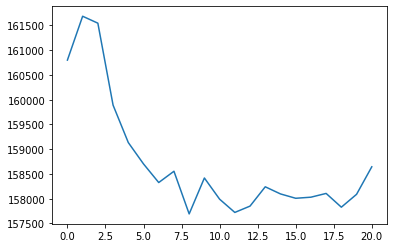

In [71]:
plt.plot(yr)

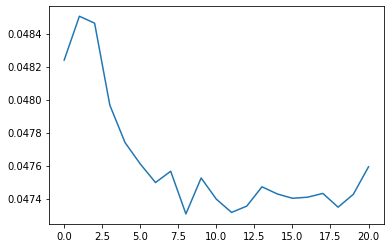

In [72]:
plt.plot(yr/np.sum(yr))

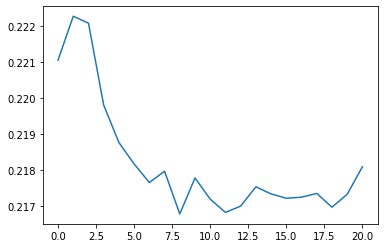

In [73]:
plt.plot(yr/np.linalg.norm(yr))

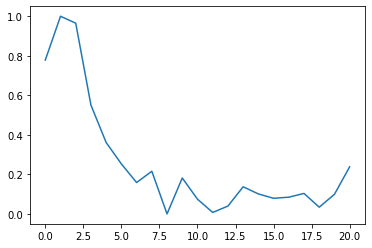

In [74]:
plt.plot(minmax(yr))

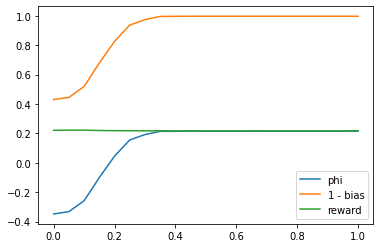

In [75]:
plt.plot(xbell, norm_r-1.0*norm_b, label="phi")

plt.plot(xbell, 1-norm_b, label="1 - bias")

plt.plot(xbell, norm_r, label="reward")

plt.legend()

0
Reward distribution: [0.83, 0.8077, 0.8088, 0.7826, 0.7015, 0.6639, 0.6658, 0.6192]
Final estimates: [0.8267, 0.8014, 0.8814, 0.7308, 0.6735, 0.6816, 0.6364, 0.697]
Presence of each in batch (%): [43.84, 28.2, 2.96, 1.32, 9.8, 11.12, 1.12, 1.64]
Relative approval rate (%): [80.02, 80.0, 79.73, 78.79, 80.0, 80.22, 78.57, 80.49]
Percentage over total selected (%): [43.83, 28.19, 2.95, 1.3, 9.8, 11.14, 1.1, 1.65]
Total reward: 157000 || and presence bias: 0.0011718140929535218
Rate bias: 0.04186844021584213
Posteriors bias: 0.9405297351324338
Rewards bias: 1.12220491406256
Final regret: 4.539230384807595
99
Reward distribution: [0.8311, 0.8086, 0.8092, 0.8002, 0.7004, 0.6697, 0.6565, 0.6159]
Final estimates: [0.827, 0.7921, 0.7667, 0.7742, 0.6526, 0.696, 0.6316, 0.6154]
Presence of each in batch (%): [44.48, 26.72, 3.0, 1.56, 9.48, 12.52, 0.96, 1.28]
Relative approval rate (%): [80.04, 79.94, 80.0, 79.49, 80.17, 79.87, 79.17, 81.25]
Percentage over total selected (%): [44.48, 26.69, 3.0

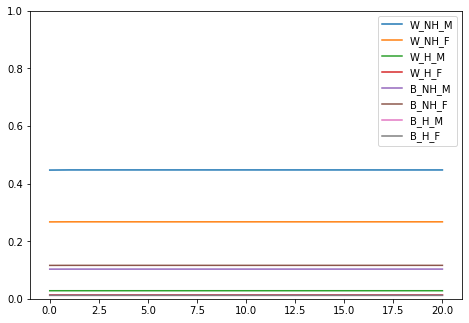

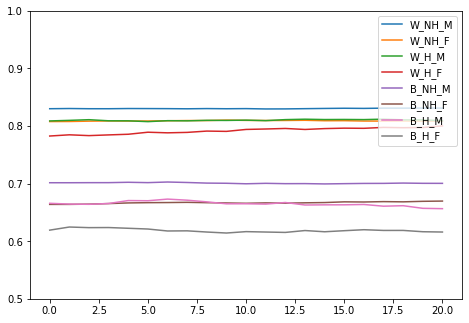

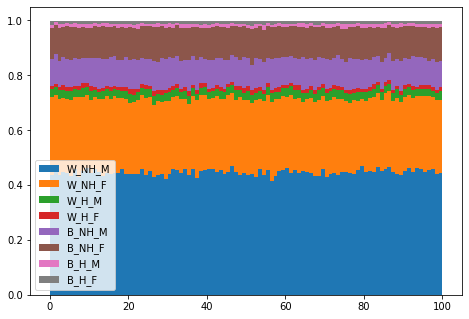

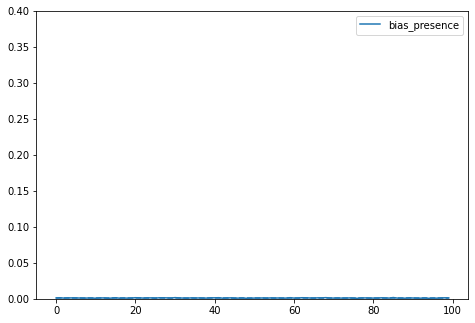

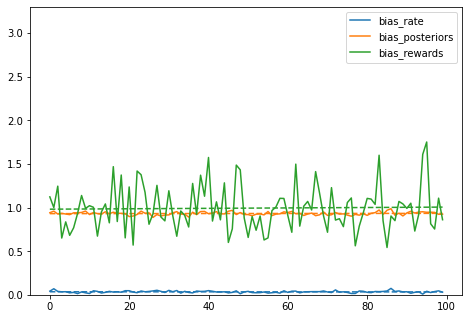

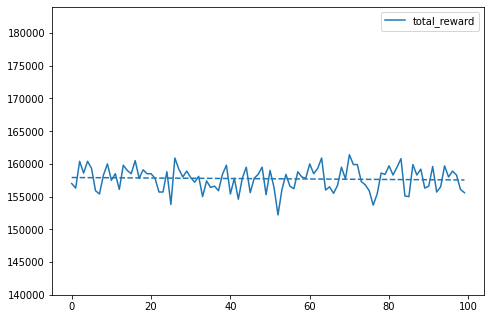

In [78]:
r = nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, maxx)

In [100]:
# Using faulty bias_rate_hipo as-is constraint
decisions = random.choices(range(8),weights=list(instances_bias),k=2500)
sol_test = solutionBatchProb(ArmProb, rewards_bias, 25, 0.9, "bias_rate_hipo")
rd = sol_test.run(decisions, 0.8, False)

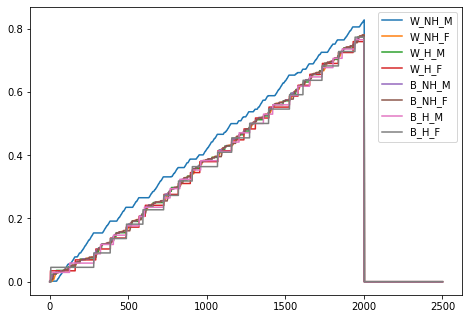

In [101]:
plot_values(rd["n_trial_tstep"]/[decisions.count(i) for i in range(8)], False, ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"])

In [103]:
# Using improved bias_rate2_hipo constraint, as explained in 5.2
decisions = random.choices(range(8),weights=list(instances_bias),k=2500)
sol_test = solutionBatchProb(ArmProb, rewards_bias, 25, 0.9, "bias_rate2_hipo")
rd = sol_test.run(decisions, 0.8, False)

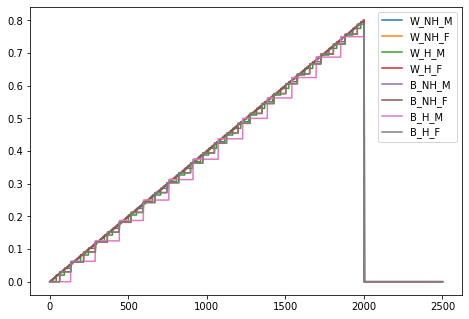

In [ ]:
plot_values(rd["n_trial_tstep"]/[decisions.count(i) for i in range(8)], False, ["W_NH_M", "W_NH_F", "W_H_M", "W_H_F", "B_NH_M", "B_NH_F", "B_H_M", "B_H_F"])

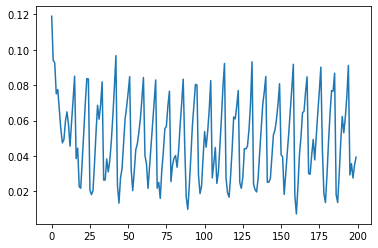

In [105]:
plt.plot(rd["rate_step"])